## Homer CTP Prediction
Using consumer characteristics from trial period, predict whether customer will convert to paid at the end of their trial

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

dir(pd.options.display)
pd.options.display.max_columns = 50

In [2]:
homer = pd.read_csv('homer_clean.csv')

### 1. EDA
- check size of dataset, datatypes, nulls
- make function to look at conversion rates by cateogry: 
    - user type vs ctp
    - distribution of total_events, completed_count by ctp
    - device type by ctp
    - average age by ctp
    - distinct days by ctp
    - distinct weeks by ctp
    - distinct titles by ctp

In [3]:
orig_columns = ['userid','path_type','multi_user_label','total_events','completed_count',
             'completed_cat','not_completed_count','event_count_cat','device_cat',
             'ipad_event','ipod_event','max_stage_complete','pathways_complete_rank',
             'pathways_reach_rank','pathways_count','alc_count','average_age_int',
             'max_stage','first_week','second_week','third_week','distinct_days',
             'avg_weekly_visit','avg_daily_hrs','weekly_visit_cat','max_days_into_trial','avg_days_from_trial',
             'trial_day','avg_level','avg_cluster','avg_step','pop_event_day','pop_title',
             'pop_category','distinct_titles','title_count_cat','max_row','max_column','avg_row','avg_col','ctp']
new_columns = [column for column in homer.columns if column not in orig_columns]

In [4]:
new_columns

['single_user',
 'multiple_user',
 'iphone_event',
 'distinct_weeks',
 'max_stage_num']

In [5]:
homer.head()

,userid,path_type,multi_user_label,single_user,multiple_user,total_events,completed_count,completed_cat,not_completed_count,event_count_cat,device_cat,ipad_event,iphone_event,ipod_event,max_stage_complete,pathways_complete_rank,pathways_reach_rank,pathways_count,alc_count,average_age_int,max_stage,first_week,second_week,third_week,distinct_weeks,distinct_days,avg_weekly_visit,avg_daily_hrs,weekly_visit_cat,max_days_into_trial,avg_days_from_trial,trial_day,max_stage_num,avg_level,avg_cluster,avg_step,pop_event_day,pop_title,pop_category,distinct_titles,title_count_cat,max_row,max_column,avg_row,avg_col,ctp
0,-9.219518e+18,"alc, pathways",Single-user,1,0,36,25,med,8,medium,iPhone,0,36,0,A,121.0,211.0,9,27,NaN,A,1,1,1,3,6,9,0,medium,21,16,14,1.0,1.0,1.0,1.0,Saturday,Letter Hunt,GAM,24,high,1.0,25.0,1.0,9.0,1
1,-9.218149e+18,pathways,Single-user,1,0,5,4,low,0,low,iPhone,0,5,0,A,121.0,211.0,5,0,1.0,A,1,0,1,2,2,3,0,low,20,4,1,1.0,1.0,1.0,1.0,Sunday,Letter Hunt,NaN,2,low,NaN,NaN,NaN,NaN,0
2,-9.217416e+18,"alc, pathways",Single-user,1,0,59,36,med,21,high,iPhone,0,59,0,C,511.0,521.0,40,19,4.0,C,1,0,0,1,2,30,0,high,5,3,8,3.0,3.0,1.0,6.0,Friday,"Make the Letters: A,a",NaN,39,high,20.0,16.0,3.0,4.0,0
3,-9.217257e+18,"alc, pathways",Single-user,1,0,126,111,very_high,14,very high,iPad,126,0,0,C,351.0,351.0,27,99,4.0,C,1,1,1,3,10,42,3,very high,16,10,5,3.0,2.0,1.0,6.0,Thursday,Swimmy,RAS,87,very high,21.0,15.0,4.0,4.0,1
4,-9.212743e+18,"alc, pathways",Multiple-user,0,1,144,105,very_high,35,very high,iPad,144,0,0,B,961.0,961.0,64,80,3.0,B,1,1,1,4,14,36,3,very high,22,7,9,2.0,5.0,1.0,4.0,Tuesday,The Airport,NaN,87,very high,28.0,16.0,2.0,3.0,1


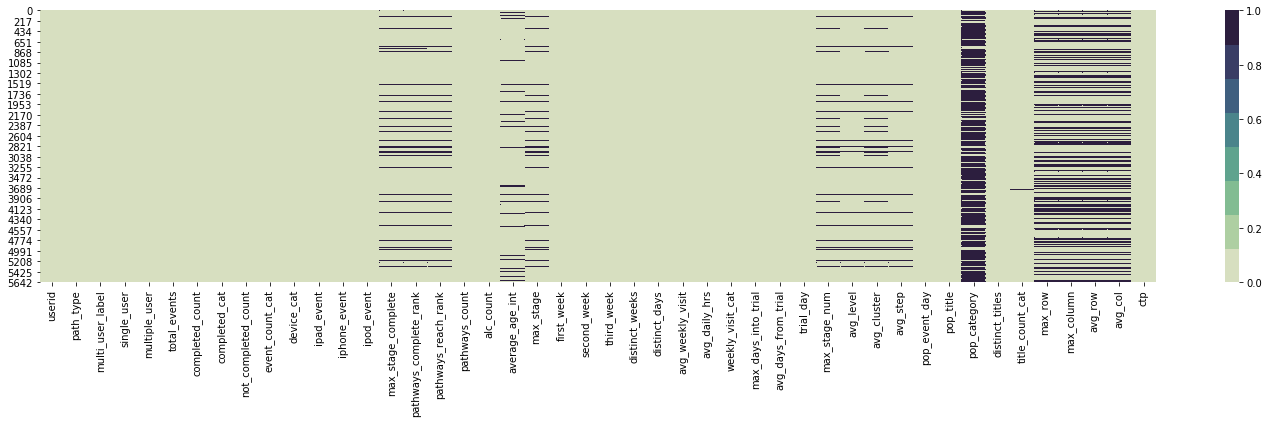

In [26]:
#visualize position of nulls in the dataset
plt.rcParams['figure.figsize'] = (25,5)
mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
sns.heatmap(homer.isnull(), cmap = mypalette)

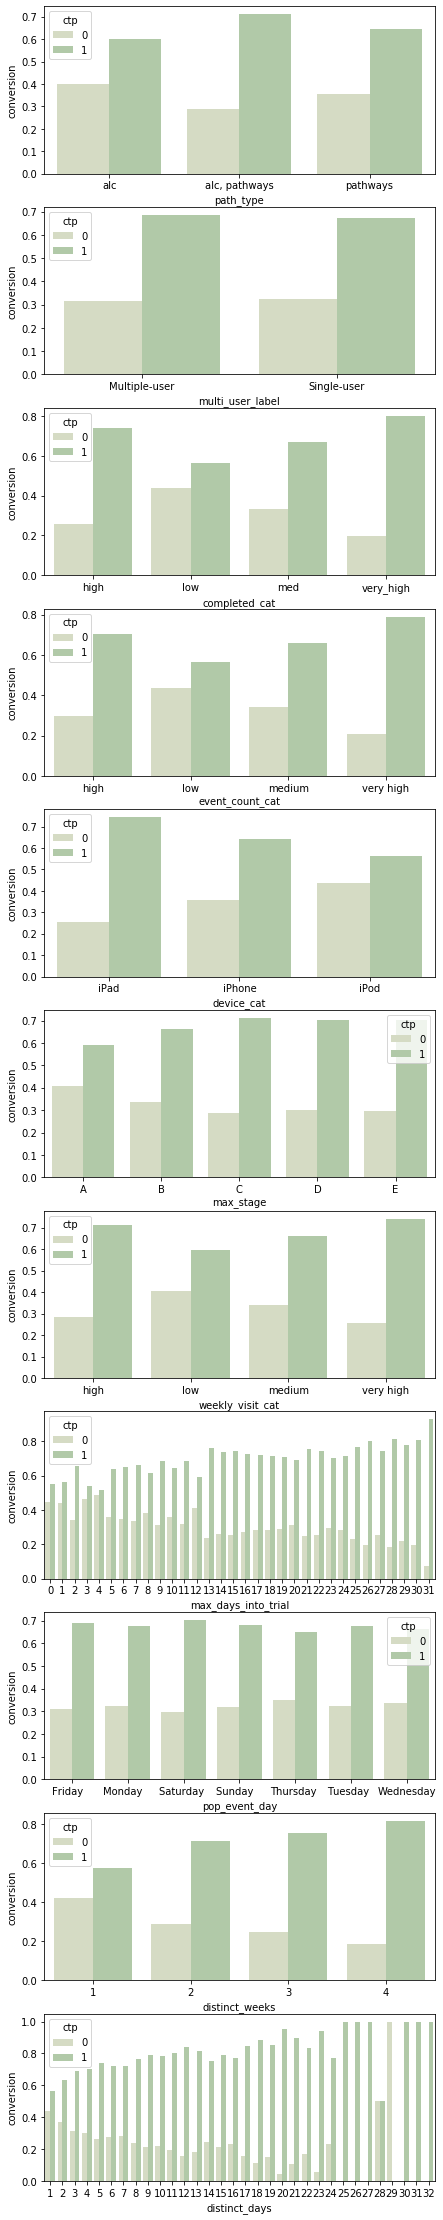

In [27]:
#visualize relationship to conversion rate for categorical variables
categorical_columns = ['path_type','multi_user_label','completed_cat','event_count_cat',
                      'device_cat','max_stage','weekly_visit_cat','max_days_into_trial','pop_event_day',
                      'distinct_weeks','distinct_days']

def plot_conversion(df, column):
    plt.rcParams['figure.figsize'] = (7,40)
    figure, axes = plt.subplots(len(categorical_columns))
    for i in range(0, len(axes)):
        category = column[i]
        grouped = df.groupby([category,'ctp'])[['ctp']].count().rename(columns={'ctp':'count'}).reset_index()
        grouped['total']=[grouped[grouped[category]==element]['count'].sum() for element in grouped[category]]
        grouped['conversion'] = grouped['count']/grouped['total']
        mypalette = (sns.cubehelix_palette(8, start=.5, rot=-.75))
        sns.barplot(grouped[category], grouped['conversion'], hue = grouped['ctp'], ax = axes[i], palette = mypalette)
        
plot_conversion(homer, categorical_columns)